# Butterfly Classification

Выполним классификацию [бабочек](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) с использованием модели [Google's EfficientNet V2](https://www.kaggle.com/models/google/efficientnet-v2).

# Import Libraries

In [1]:
%%capture

import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt

from PIL import Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.layers import Dense, Dropout, Conv2D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm

# Disable error output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Detect Current Accelerator

Для быстрого обучения будем использовать Tensor Processing Units (TPU).

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection.
    print('Running on TPU ', tpu.master())
except ValueError:
    print("No TPUs detected")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
REPLICAS:  8


# Load Data

In [3]:
INPUT_DIR = "../input/butterfly-image-classification"
TRAIN_DIR = f"{INPUT_DIR}/train"
TEST_DIR = f"{INPUT_DIR}/test"

meta_df = pd.read_csv(os.path.join(INPUT_DIR, "Training_set.csv"))
meta_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [4]:
meta_df.shape

(6499, 2)

## Data Pre-Processing

Сформируем датасет с картинками и классами (label).

К классам применим LabelEncoder, чтобы от категориальных признаков перейти к численным

In [5]:
# %%capture

images = []
labels = []
label_encodings = []

label_encoder = LabelEncoder()
meta_df["label_encoding"] = label_encoder.fit_transform(meta_df["label"])

ohe = OneHotEncoder()
encoder_df = pd.DataFrame(ohe.fit_transform(meta_df[['label_encoding']]).toarray())

# Присоединим столбцы one-hot encoded к датафрейму
meta_df = meta_df.join(encoder_df)
pbar = tqdm(list(meta_df.iterrows()))

for index, entry in pbar:
    image = np.asarray(Image.open(os.path.join(TRAIN_DIR, entry["filename"])))
    label = entry["label"]
    label_encoding = entry[3:]

    images.append(image)
    labels.append(label)
    label_encodings.append(label_encoding)
    pbar.update()

100%|██████████| 6499/6499 [00:27<00:00, 233.41it/s]


Посмотрим на размеры первого изображения:

In [6]:
images[0].shape

(224, 224, 3)

Классы имеют следующий вид:

In [7]:
labels[0:10]

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'GREEN CELLED CATTLEHEART',
 'EASTERN DAPPLE WHITE',
 'BROWN SIPROETA',
 'RED POSTMAN']

Те же классы в численном выражении:

In [8]:
label_encodings[0]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
70    0.0
71    0.0
72    0.0
73    0.0
74    0.0
Name: 0, Length: 75, dtype: object

## Visualizing Data

Рассмотрим несколько картинок из датасета.

<Figure size 640x480 with 0 Axes>

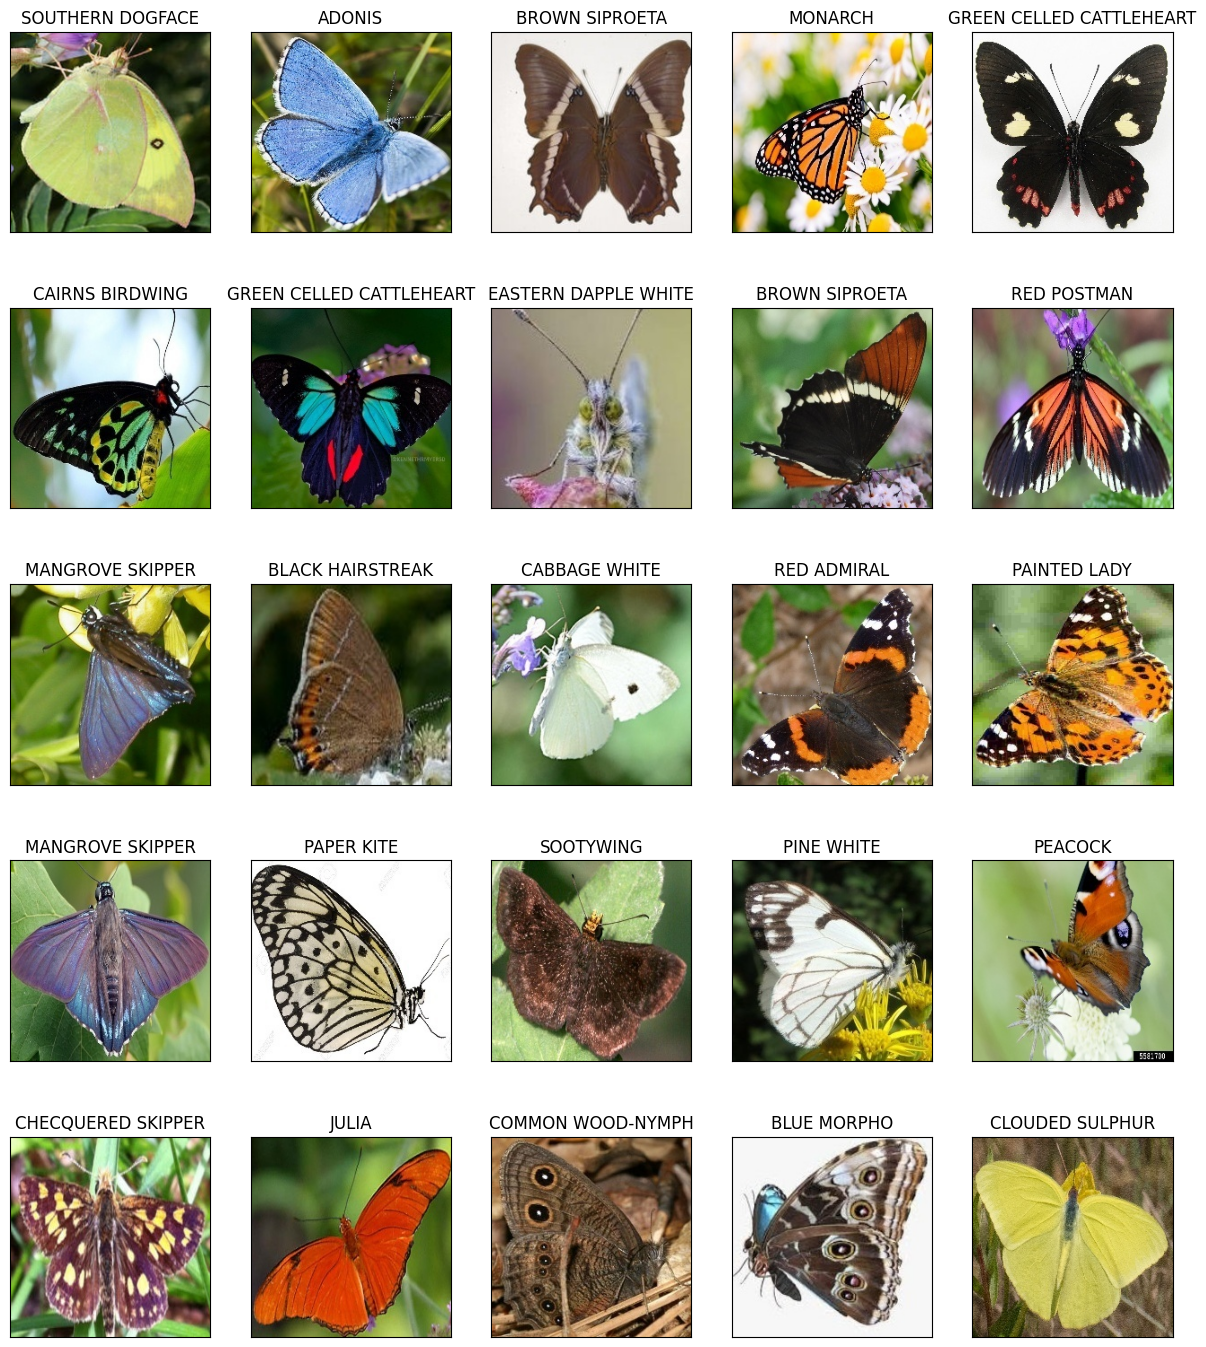

In [9]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
plt.subplots_adjust(top=1.0)

for idx, ax in enumerate(axes.flat):
    image = images[idx]
    label_name = labels[idx]
    
    ax.imshow(image)
    ax.set(title=label_name)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Distribution of Labels

Посмотрим на распределение целевой переменной.

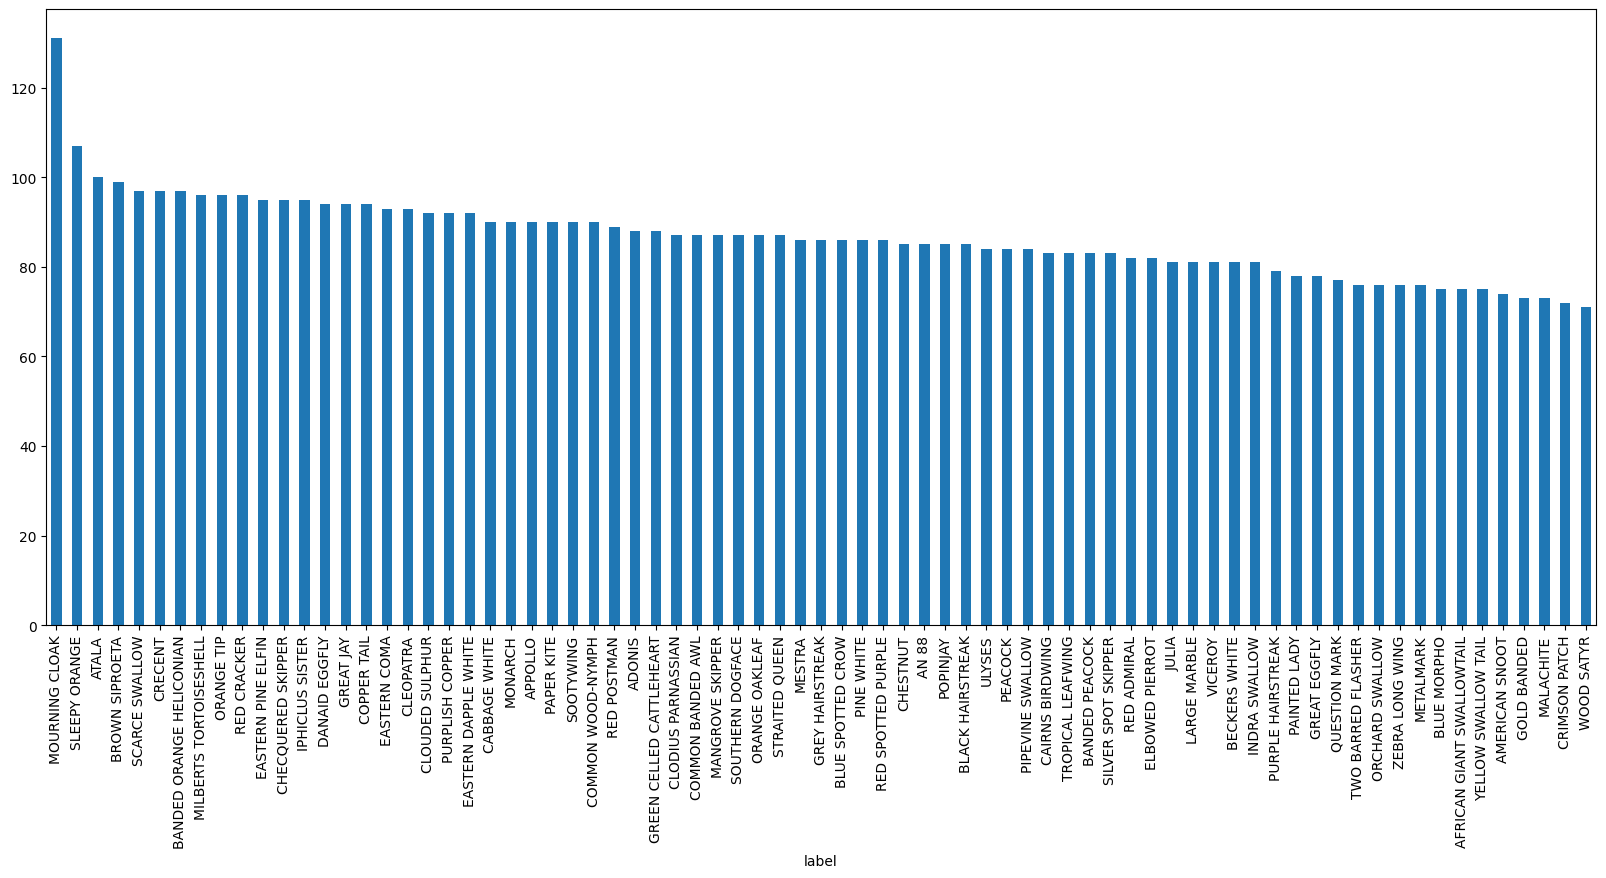

In [10]:
plt.figure(figsize=(20, 8))
meta_df["label"].value_counts().plot(kind="bar")
plt.show()

# Modelling

Мы будем использовать нейронную сеть с Efficient Net V2 для классификации различных категорий бабочек.

In [11]:
with strategy.scope():
    efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",
                   trainable=False)
    
    model = keras.Sequential([
        efficient_net,
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(75, activation='softmax'),
    ])
    
    model.build([None, 224, 224, 3])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

Наша модель имеет следующий вид:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 75)                9675      
                                                                 
Total params: 13366665 (50.99 MB)
Trainable params: 436043 (1.66 MB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


## Training the Model


Теперь мы скомпилируем и обучим модель. Сначала нам нужно преобразовать наши изображения и метки в массивы Numpy, а затем разделить наши изображения и метки на обучающий и тестовый наборы:

In [13]:
np_images = np.asarray(images).astype('float64') / 255
np_label_encodings = np.asarray(label_encodings).astype('int8')
print(f"Shape of images: {np_images.shape}")
print(f"Shape of label encodings: {np_label_encodings.shape}")

Shape of images: (6499, 224, 224, 3)
Shape of label encodings: (6499, 75)


In [14]:
images_train, images_test, label_encodings_train, label_encodings_test = train_test_split(np_images, np_label_encodings, train_size=0.7)
print(f"Shape of training images: {images_train.shape}")
print(f"Shape of training label encodings: {label_encodings_train.shape}")
print(f"Shape of validation images: {images_test.shape}")
print(f"Shape of validation label encodings: {label_encodings_test.shape}")

Shape of training images: (4549, 224, 224, 3)
Shape of training label encodings: (4549, 75)
Shape of validation images: (1950, 224, 224, 3)
Shape of validation label encodings: (1950, 75)


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, label_encodings_train)).repeat().shuffle(10000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, label_encodings_test)).batch(5)

In [16]:
EPOCHS = 5
STEPS_PER_EPOCH = 2000

history = model.fit(x=train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_dataset)

Epoch 1/5
2000/2000 [==============================] - 284s 132ms/step - loss: 0.1519 - categorical_accuracy: 0.9658 - val_loss: 0.4047 - val_categorical_accuracy: 0.8974
Epoch 2/5
2000/2000 [==============================] - 231s 116ms/step - loss: 0.0097 - categorical_accuracy: 0.9978 - val_loss: 0.4860 - val_categorical_accuracy: 0.9000
Epoch 3/5
2000/2000 [==============================] - 232s 116ms/step - loss: 0.0099 - categorical_accuracy: 0.9974 - val_loss: 0.5416 - val_categorical_accuracy: 0.9041
Epoch 4/5
2000/2000 [==============================] - 232s 116ms/step - loss: 7.7209e-04 - categorical_accuracy: 0.9998 - val_loss: 0.5512 - val_categorical_accuracy: 0.9056
Epoch 5/5
2000/2000 [==============================] - 233s 116ms/step - loss: 0.0096 - categorical_accuracy: 0.9973 - val_loss: 0.5917 - val_categorical_accuracy: 0.9026


# Visualizing Model Accuracy

Мы можем визуализировать, насколько хорошо наша модель справляется с набором проверок, сопоставляя предсказания с изображениями в наборе проверок и проверяя, соответствуют ли они фактическим меткам.

25/25 [==============================] - 14s 32ms/step


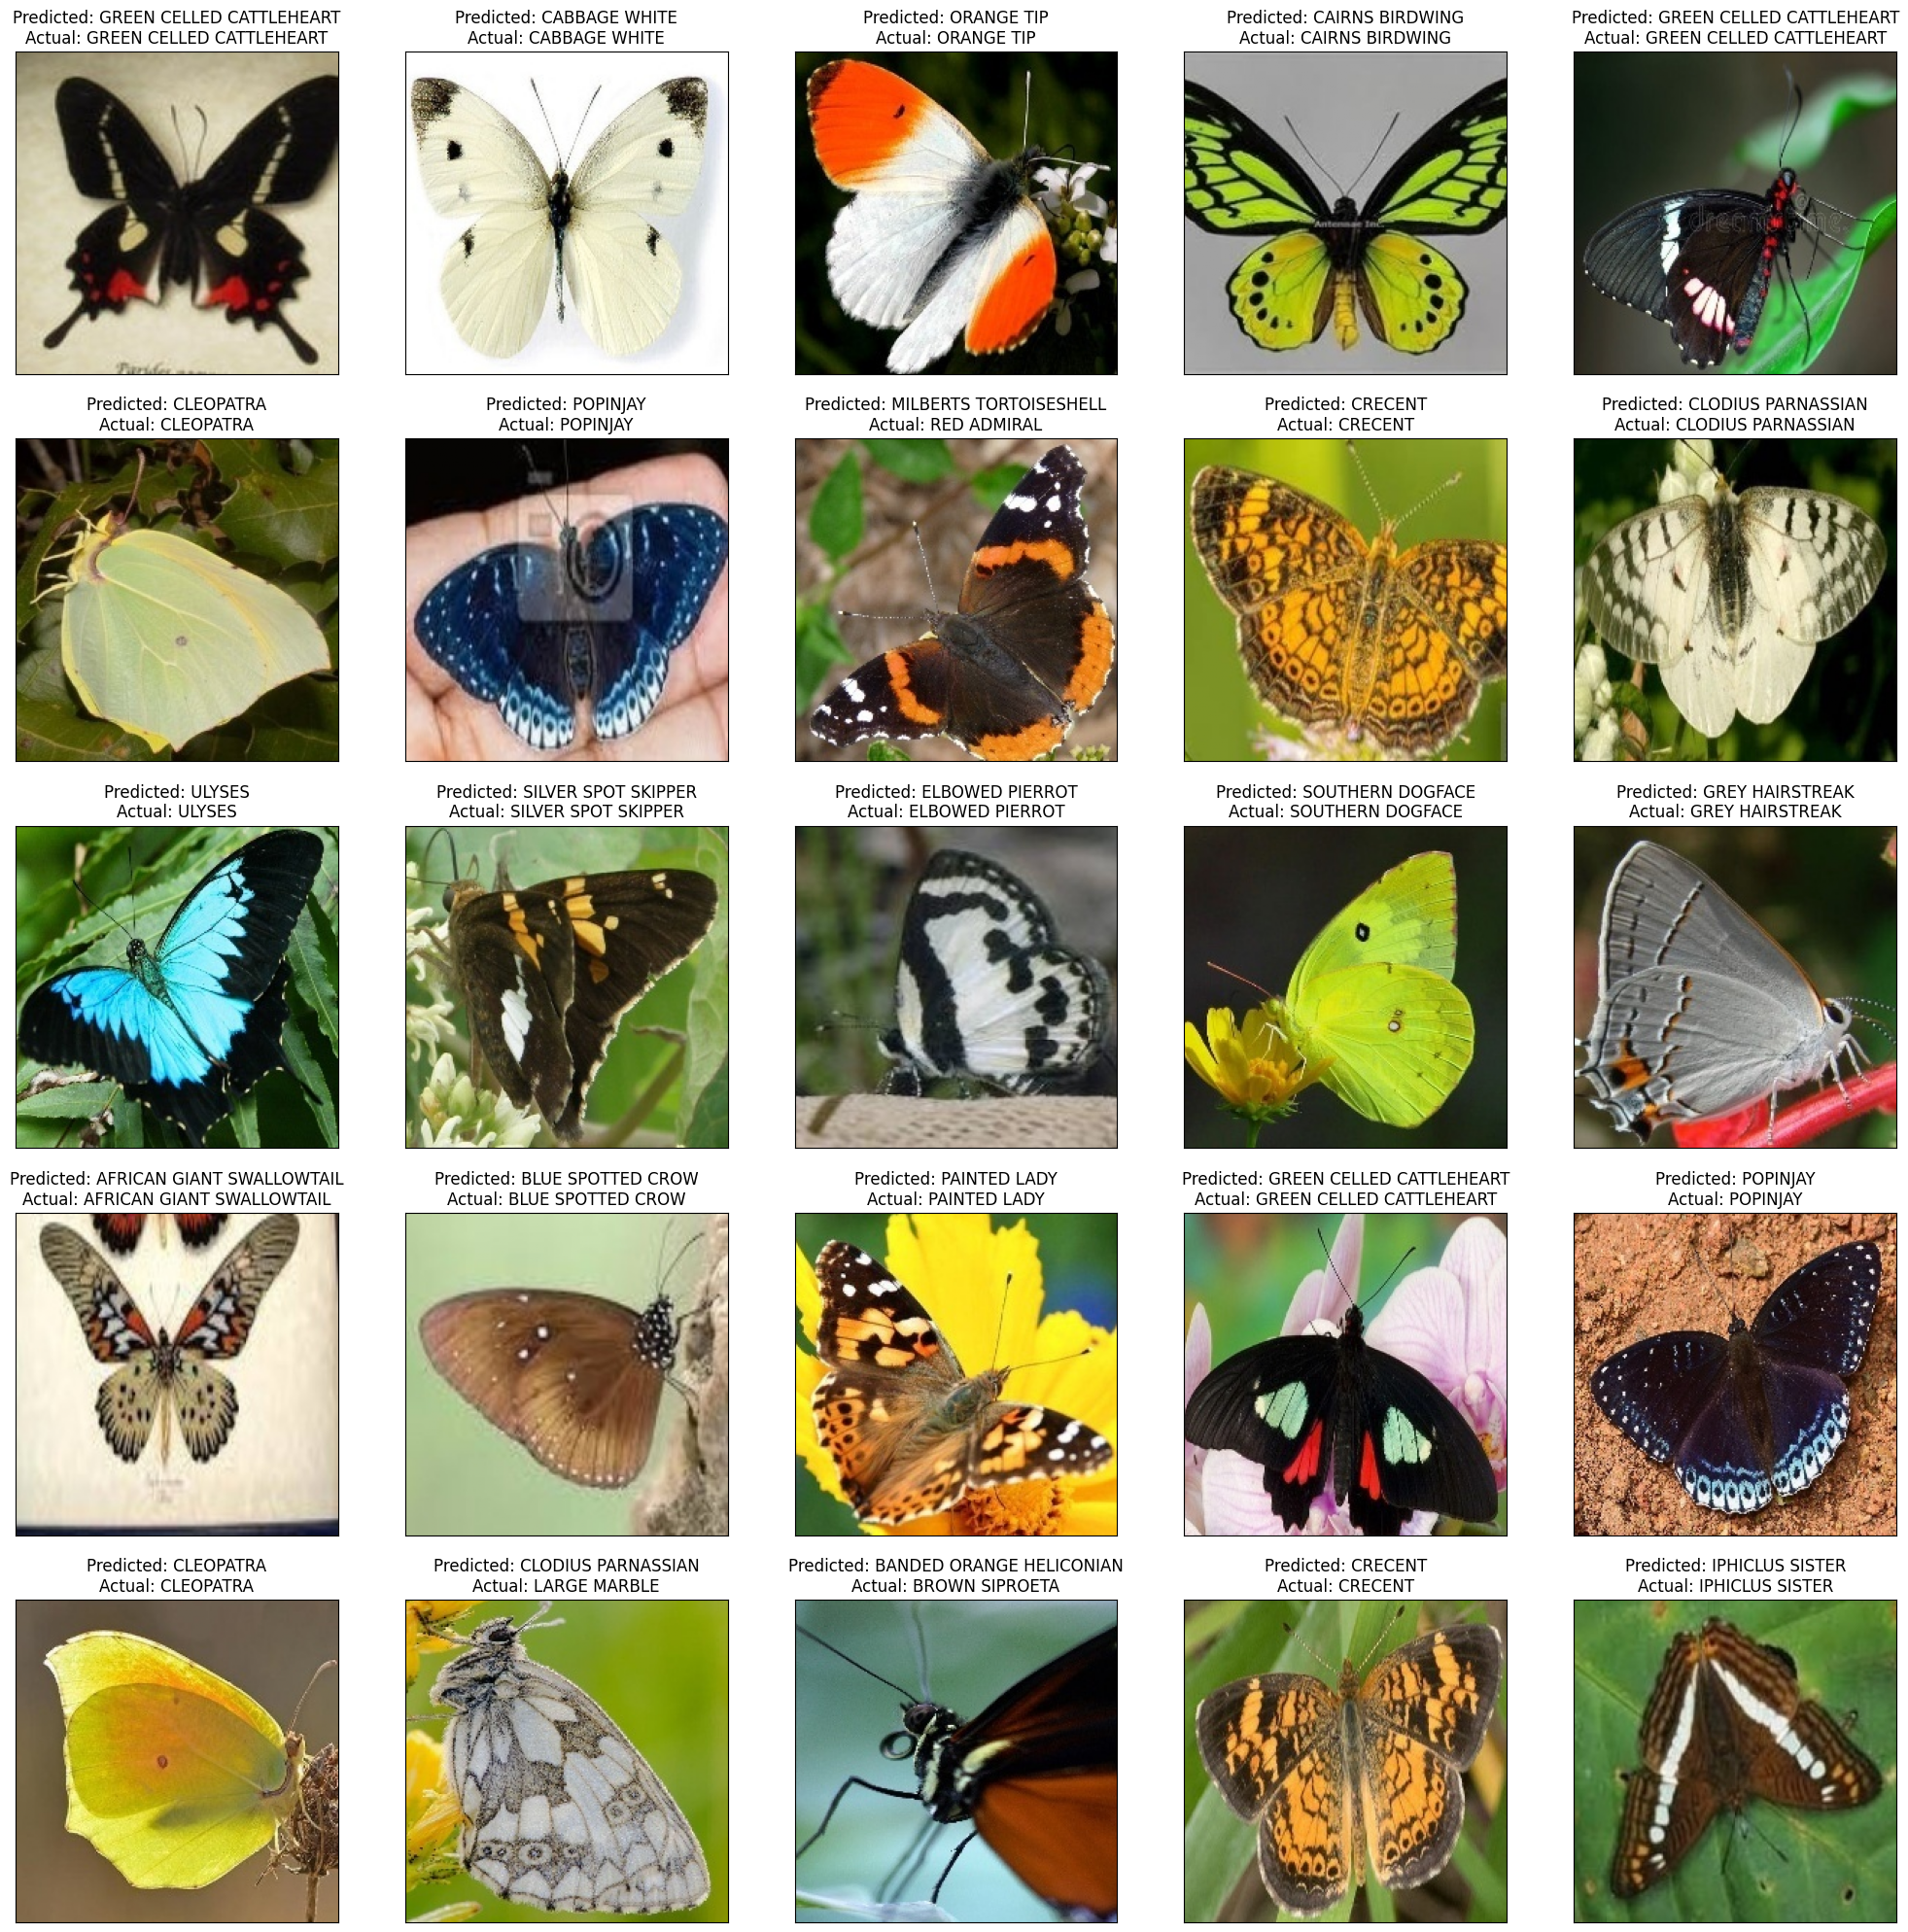

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25,25))

test_dataset = tf.data.Dataset.from_tensor_slices((images_test, label_encodings_test)).batch(1)
sample_test_dataset = test_dataset.take(25)
sample_test_dataset_np = [(image, label_encoding) for (image, label_encoding) in sample_test_dataset]
predictions = model.predict(sample_test_dataset).argmax(axis=1)

for ax, (image, act_label_encoding), pred_label_encoding in zip(axes.flat, sample_test_dataset, predictions):
    
    actual_label_encoding_np = act_label_encoding.numpy()[0]
    actual_label_number = ohe.inverse_transform([actual_label_encoding_np])[0]
    actual_label_name = label_encoder.inverse_transform([actual_label_number])[0]
    
    pred_label_encoding_np = pred_label_encoding.astype(int)
    pred_label_name = label_encoder.inverse_transform([pred_label_encoding_np])[0]
    
    ax.imshow(image.numpy().reshape(224, 224, 3))
    ax.set(title=f"Predicted: {pred_label_name}\nActual: {actual_label_name}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

# Evaluating Model

## Precision, Accuracy, Recall, F1

Оценим нашу модель:

In [18]:
test_predictions = model.predict(test_dataset).argmax(axis=1).astype(int)

test_actual = [int(np.where(label_encoding.numpy() == 1)[1]) for (image, label_encoding) in test_dataset]

1950/1950 [==============================] - 67s 32ms/step


In [19]:
print(f"Accuracy: {accuracy_score(test_predictions, test_actual)}")
print(f"Precision: {precision_score(test_predictions, test_actual, average='macro')}")
print(f"Recall: {recall_score(test_predictions, test_actual, average='macro')}")
print(f"F1 score: {f1_score(test_predictions, test_actual, average='macro')}")

Accuracy: 0.9025641025641026
Precision: 0.9028131903435849
Recall: 0.9054159559820202
F1 score: 0.9009024656042008


## Confusion Matrix

Составим матрицу ошибок (матрицу "путаницы").

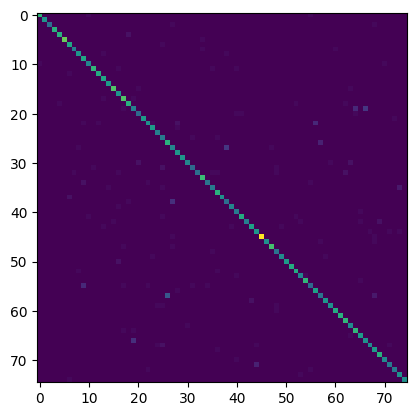

In [20]:
confusion_matrix = tf.math.confusion_matrix(test_actual, test_predictions)
plt.imshow(confusion_matrix)
plt.show()

## Save model

In [21]:
model.save('model.h5')
tf.saved_model.save(model, '/model')

INFO:tensorflow:Assets written to: /model/assets


## Summary

Для увеличения выборки можно воспользоваться аугментацией. Но это усложнит модель и значительно увеличит время обучения.

## 